In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
%matplotlib inline

import sys
import os
import copy
import random
import datetime

import numpy as np
import pickle
import glob
from tqdm import tqdm
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch import optim
from pycocotools.coco import COCO

In [3]:
sys.path.append('../src/')

from SSAP import SSAP
from mydatasets import preprocess
import mydatasets as datasets
from loss import focal_loss, l2_loss, calc_loss
from graph_partition import Partition, Edge, greedy_additive, \
                            calc_js_div, make_ins_seg

def num_parameters(m):
    return sum([np.prod(v.shape) for v in m.parameters()])

/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):
/home/dbear/tenv/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:568: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## load model and get dataset

In [15]:
name = '../exp/raftsup_0pretrain_0/'
trained_model = name + 'trained_model'

os.listdir(trained_model)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['model_50000.pth',
 'model_40000.pth',
 'model_10000.pth',
 'model_30000.pth',
 'model_20000.pth']

In [9]:
mean = [0.477, 0.451, 0.411]
std = [0.284, 0.280, 0.292]

tdw_dataset = datasets.TdwAffinityDataset(training=False, mean=mean, std=std, 
                                          raft_ckpt=None, 
                                          single_supervision=False,
                                          full_supervision=True)

print(len(tdw_dataset))

500


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


device(type='cuda', index=0)

In [17]:
ckpt_iter = 50000
load_path = os.path.join(trained_model, 'model_' + str(ckpt_iter) + '.pth')
use_pretrained = False

AFF_R = 5
model = SSAP(n_channels=3, n_classes=2, aff_r=AFF_R, pretrained_backbone=use_pretrained)
model = model.to(device)

did_load = model.load_state_dict(torch.load(load_path)) 
model.eval()
print(did_load)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully>


### check eval on single example

In [18]:
ex = 3
img, cats, _ = [x[None].cuda() for x in tdw_dataset[ex]]
outputs = model(img)
ins, ins_list = make_ins_seg(outputs, st_for=0,
                            en_for=5, min_size=5)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[  0  15  37  71 146 180 237]


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


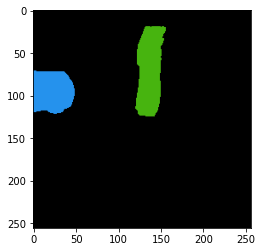

In [19]:
cls_ = 0
print(np.unique(ins[cls_]))
plt.imshow(ins[cls_])
plt.show()